In [516]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import tensorflow as tf

import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter

from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, mean_squared_error

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor


In [517]:
"""
sample_submission = pd.read_csv("/kaggle/input/iyzico-datathon/sample_submission.csv")
base_train = pd.read_csv("/kaggle/input/iyzico-datathon/train.csv")
"""

sample_submission = pd.read_csv("sample_submission.csv")
base_train = pd.read_csv("train.csv")

In [518]:
base_train

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
0,merchant_43992,202307,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,15106
1,merchant_43992,202301,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16918
2,merchant_43992,202305,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,13452
3,merchant_43992,202308,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16787
4,merchant_43992,202302,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,12428
...,...,...,...,...,...,...,...,...
291137,merchant_67083,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,4
291138,merchant_4263,202309,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_73,Segment - 4,4
291139,merchant_11346,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,3
291140,merchant_21397,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_168,Segment - 4,3


In [519]:
# ORIGINAL DATA
print('Original data shape:', base_train.shape )

# SS
print('Sample submission data shape:', sample_submission.shape )

Original data shape: (291142, 8)
Sample submission data shape: (78180, 2)


In [520]:
# FEATURE ENGINEERING 
df = base_train.copy()
"""train = df.loc[df.index < '2023-04-01']
test = df.loc[df.index >= '2023-04-01']"""


df['datetime'] = pd.to_datetime(df['month_id'], format='%Y%m')
df = df.sort_values(["merchant_id", "datetime"])

df.set_index('datetime', inplace=True)

# Create a DataFrame with all possible combinations of 'datetime' and 'merchant_id'
all_dates = pd.date_range(start='2020-01-01', end='2023-09-01', freq='MS')
all_merchant_ids = df['merchant_id'].unique()
df_all_combinations = pd.DataFrame(index=pd.MultiIndex.from_product([all_dates, all_merchant_ids], names=['datetime', 'merchant_id'])).reset_index()

# Filter out the rows that are already present in the original DataFrame
existing_rows = pd.merge(df, df_all_combinations, on=['datetime', 'merchant_id'], how='right')

# Forward fill missing values for specified columns
columns_to_ffill = ['merchant_source_name', 'settlement_period', 'working_type', 'mcc_id', 'merchant_segment']
existing_rows[columns_to_ffill] = existing_rows.groupby('merchant_id')[columns_to_ffill].ffill()

# Fill missing 'net_payment_count' with 0
existing_rows['net_payment_count'] = existing_rows['net_payment_count'].fillna(0)

df = existing_rows.copy()
df.set_index('datetime', inplace=True)

df['month'] = df.index.month
df['year'] = df.index.year
# Add a column to represent summer solstice for the entire month
df['summer_solstice'] = (df['month'] == 6).astype(int)  # June

# Add a column to represent Black Friday for the entire month of November
df['black_friday'] = (df['month'] == 11).astype(int)  # November
    
print('Data shape: ',df.shape)

df

Data shape:  (1172700, 12)


,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,month,year,summer_solstice,black_friday
datetime,,,,,,,,,,,,
2020-01-01,merchant_1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,2020,0,0
2020-01-01,merchant_10,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,2020,0,0
2020-01-01,merchant_10000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,2020,0,0
2020-01-01,merchant_10001,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,2020,0,0
2020-01-01,merchant_10002,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,2020,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,merchant_9984,202309.0,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_35,Segment - 4,5.0,9,2023,0,0
2023-09-01,merchant_9985,NaN,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_168,Segment - 4,0.0,9,2023,0,0
2023-09-01,merchant_9986,NaN,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_35,Segment - 4,0.0,9,2023,0,0


In [521]:
df[df.merchant_id == "merchant_10006"]

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,month,year,summer_solstice,black_friday
datetime,,,,,,,,,,,,
2020-01-01,merchant_10006,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,2020,0,0
2020-02-01,merchant_10006,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2,2020,0,0
2020-03-01,merchant_10006,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3,2020,0,0
2020-04-01,merchant_10006,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4,2020,0,0
2020-05-01,merchant_10006,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5,2020,0,0
2020-06-01,merchant_10006,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6,2020,1,0
2020-07-01,merchant_10006,NaN,NaN,NaN,NaN,NaN,NaN,0.0,7,2020,0,0
2020-08-01,merchant_10006,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8,2020,0,0
2020-09-01,merchant_10006,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9,2020,0,0


In [522]:
# Group the original DataFrame by 'merchant_id' and fill missing values with mode
grouped = df.groupby('merchant_id')[['merchant_source_name', 'settlement_period', 'working_type', 'mcc_id', 'merchant_segment']].apply(lambda x: x.mode().iloc[0])

# Fill missing values for the specified columns with mode
df[['merchant_source_name', 'settlement_period', 'working_type', 'mcc_id', 'merchant_segment']] = df.groupby('merchant_id')[['merchant_source_name', 'settlement_period', 'working_type', 'mcc_id', 'merchant_segment']].transform(lambda x: x.fillna(x.mode().iloc[0]))
df = df.sort_values(["merchant_id", "datetime"])

df

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,month,year,summer_solstice,black_friday
datetime,,,,,,,,,,,,
2020-01-01,merchant_1,NaN,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,1,2020,0,0
2020-02-01,merchant_1,NaN,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,2,2020,0,0
2020-03-01,merchant_1,NaN,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,3,2020,0,0
2020-04-01,merchant_1,NaN,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,4,2020,0,0
2020-05-01,merchant_1,NaN,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,5,2020,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,merchant_9993,NaN,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,0.0,5,2023,0,0
2023-06-01,merchant_9993,202306.0,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,4.0,6,2023,1,0
2023-07-01,merchant_9993,NaN,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,0.0,7,2023,0,0


In [523]:
df['month_id'] = df.index.strftime('%Y%m')

df

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,month,year,summer_solstice,black_friday
datetime,,,,,,,,,,,,
2020-01-01,merchant_1,202001,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,1,2020,0,0
2020-02-01,merchant_1,202002,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,2,2020,0,0
2020-03-01,merchant_1,202003,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,3,2020,0,0
2020-04-01,merchant_1,202004,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,4,2020,0,0
2020-05-01,merchant_1,202005,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,5,2020,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,merchant_9993,202305,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,0.0,5,2023,0,0
2023-06-01,merchant_9993,202306,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,4.0,6,2023,1,0
2023-07-01,merchant_9993,202307,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,0.0,7,2023,0,0


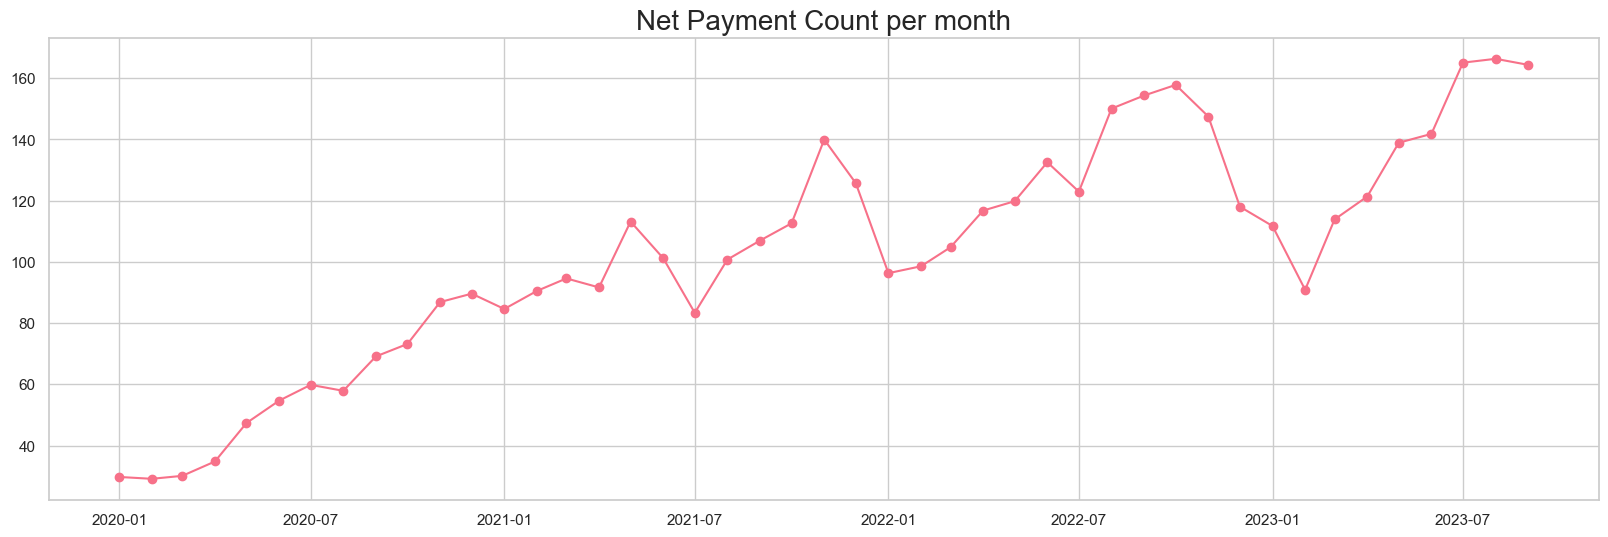

In [524]:
tmp = df.groupby("datetime").net_payment_count.mean()
plt.figure(figsize=(20,6))
plt.plot(tmp.index, tmp,'-o')
plt.title('Net Payment Count per month',size=20)
plt.show()

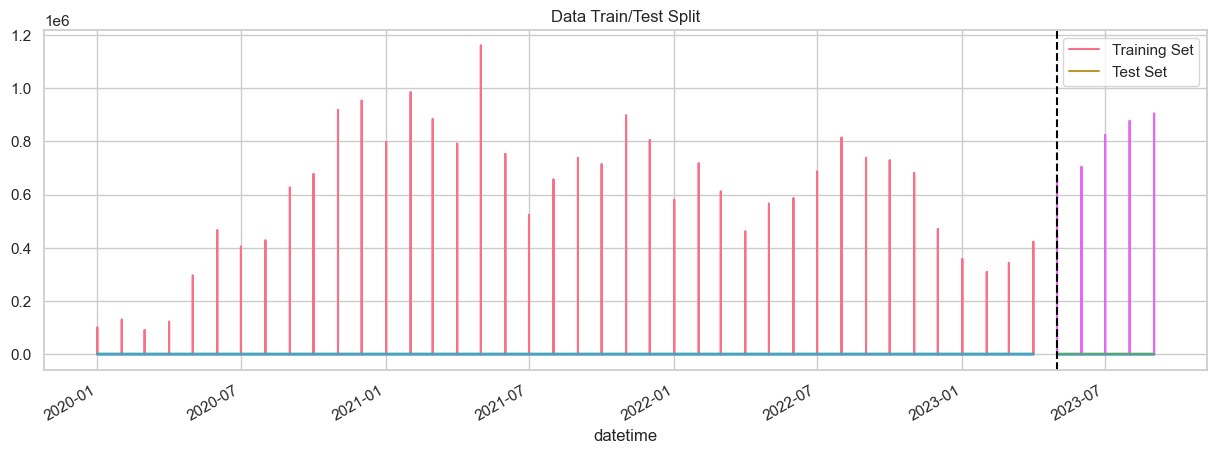

In [525]:
#df.set_index('datetime', inplace=True)

train = df.loc[df.index < '2023-05-01']
test = df.loc[df.index >= '2023-05-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2023-05-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [526]:
# Group the DataFrame by merchant_id and calculate the mean of net_payment_count for each group
average_payment_by_merchant = df.groupby('merchant_id')['net_payment_count'].mean()

# Print the average net_payment_count for each unique merchant_id
print(average_payment_by_merchant)
df.reset_index(inplace=True)

# Merge the average payment by merchant_id with your original DataFrame
df = pd.merge(df, average_payment_by_merchant.rename('avg_net_payment_count'), on='merchant_id', how='left')
df.drop("avg_net_payment_count" , axis=1, inplace=True)
# Reset the index to restore the datetime index
df.set_index('datetime', inplace=True)

merchant_id
merchant_1        0.133333
merchant_10       1.444444
merchant_10000    1.155556
merchant_10001    5.266667
merchant_10002    0.422222
                    ...   
merchant_9984     1.066667
merchant_9985     0.088889
merchant_9986     0.488889
merchant_9991     3.555556
merchant_9993     0.533333
Name: net_payment_count, Length: 26060, dtype: float64


In [527]:
df

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,month,year,summer_solstice,black_friday
datetime,,,,,,,,,,,,
2020-01-01,merchant_1,202001,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,1,2020,0,0
2020-02-01,merchant_1,202002,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,2,2020,0,0
2020-03-01,merchant_1,202003,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,3,2020,0,0
2020-04-01,merchant_1,202004,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,4,2020,0,0
2020-05-01,merchant_1,202005,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,5,2020,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,merchant_9993,202305,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,0.0,5,2023,0,0
2023-06-01,merchant_9993,202306,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,4.0,6,2023,1,0
2023-07-01,merchant_9993,202307,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,0.0,7,2023,0,0


In [528]:
df['m'] = df.groupby('merchant_id').net_payment_count.transform('max')
def latest_non_zero(x):
    non_zero_values = x[x != 0]
    if len(non_zero_values) > 0:
        return non_zero_values.iloc[-1]
    else:
        return np.nan

df['latest_non_zero_net_payment_count'] = df.groupby('merchant_id')['net_payment_count'].transform(latest_non_zero)


df

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,month,year,summer_solstice,black_friday,m,latest_non_zero_net_payment_count
datetime,,,,,,,,,,,,,,
2020-01-01,merchant_1,202001,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,1,2020,0,0,3.0,3.0
2020-02-01,merchant_1,202002,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,2,2020,0,0,3.0,3.0
2020-03-01,merchant_1,202003,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,3,2020,0,0,3.0,3.0
2020-04-01,merchant_1,202004,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,4,2020,0,0,3.0,3.0
2020-05-01,merchant_1,202005,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,5,2020,0,0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,merchant_9993,202305,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,0.0,5,2023,0,0,8.0,4.0
2023-06-01,merchant_9993,202306,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,4.0,6,2023,1,0,8.0,4.0
2023-07-01,merchant_9993,202307,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,0.0,7,2023,0,0,8.0,4.0


In [529]:
df

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,month,year,summer_solstice,black_friday,m,latest_non_zero_net_payment_count
datetime,,,,,,,,,,,,,,
2020-01-01,merchant_1,202001,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,1,2020,0,0,3.0,3.0
2020-02-01,merchant_1,202002,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,2,2020,0,0,3.0,3.0
2020-03-01,merchant_1,202003,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,3,2020,0,0,3.0,3.0
2020-04-01,merchant_1,202004,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,4,2020,0,0,3.0,3.0
2020-05-01,merchant_1,202005,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,5,2020,0,0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,merchant_9993,202305,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,0.0,5,2023,0,0,8.0,4.0
2023-06-01,merchant_9993,202306,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,4.0,6,2023,1,0,8.0,4.0
2023-07-01,merchant_9993,202307,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,0.0,7,2023,0,0,8.0,4.0


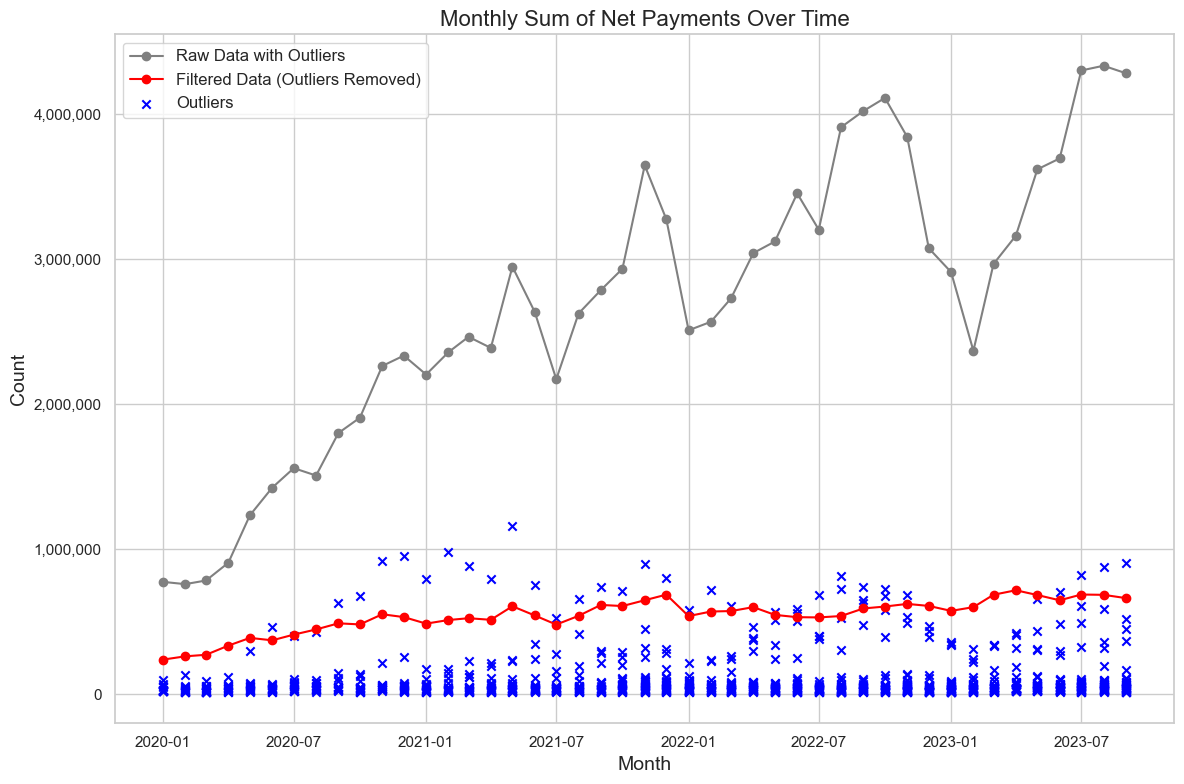

In [530]:
monthly_counts = df.groupby('datetime')['net_payment_count'].sum()
rolling_avg = monthly_counts.rolling(window=3, min_periods=1).mean()


# Calculate z-scores for each net_payment_count value
z_scores = (df['net_payment_count'] - df['net_payment_count'].mean()) / df['net_payment_count'].std()

# Define a threshold for outlier detection
threshold = 3

# Filter out data points with z-scores greater than the threshold (outliers)
outliers = df[abs(z_scores) >= threshold]

# Filter out data points with z-scores less than the threshold (non-outliers)
filtered_data = df[abs(z_scores) < threshold]


# Group by month_id and sum the net_payment_count for each month for both original and filtered data
monthly_counts = df.groupby('datetime')['net_payment_count'].sum()
filtered_monthly_counts = filtered_data.groupby('datetime')['net_payment_count'].sum()

# Set up a seaborn style for better aesthetics
sns.set(style="whitegrid", palette="husl")

# Define a function to format y-axis ticks
def format_ticks(value, _):
    return f'{int(value):,}'

# Plotting
plt.figure(figsize=(12, 8))

# Plot raw monthly counts with outliers
plt.plot(monthly_counts.index, monthly_counts.values, color='gray', marker='o', linestyle='-', label='Raw Data with Outliers')

# Plot filtered monthly counts without outliers
plt.plot(filtered_monthly_counts.index, filtered_monthly_counts.values, color='red', marker='o', linestyle='-', label='Filtered Data (Outliers Removed)')

# Plot outliers
plt.scatter(outliers.index, outliers['net_payment_count'], color='blue', marker='x', label='Outliers')

# Apply the formatting function to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.title('Monthly Sum of Net Payments Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

In [531]:
KEEP = filtered_data.merchant_id.unique()
print('We will train with', len(KEEP),'non-outlier merchants')

SMALL = filtered_data.merchant_id.nunique() - len(KEEP)
print('There are ',SMALL,' merchant_ids outliers needed to be removed')

print('There are ',len(outliers),' outlier data needed to be removed')

We will train with 26053 non-outlier merchants
There are  0  merchant_ids outliers needed to be removed
There are  1036  outlier data needed to be removed


In [532]:
filtered_data

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,month,year,summer_solstice,black_friday,m,latest_non_zero_net_payment_count
datetime,,,,,,,,,,,,,,
2020-01-01,merchant_1,202001,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,1,2020,0,0,3.0,3.0
2020-02-01,merchant_1,202002,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,2,2020,0,0,3.0,3.0
2020-03-01,merchant_1,202003,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,3,2020,0,0,3.0,3.0
2020-04-01,merchant_1,202004,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,4,2020,0,0,3.0,3.0
2020-05-01,merchant_1,202005,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0.0,5,2020,0,0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,merchant_9993,202305,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,0.0,5,2023,0,0,8.0,4.0
2023-06-01,merchant_9993,202306,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,4.0,6,2023,1,0,8.0,4.0
2023-07-01,merchant_9993,202307,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,0.0,7,2023,0,0,8.0,4.0


In [533]:
"""# Create a DataFrame with all possible combinations of 'datetime' and 'merchant_id'
all_dates = pd.date_range(start='2020-01-01', end='2023-09-01', freq='MS')
all_merchant_ids = df['merchant_id'].unique()
df_all_combinations = pd.DataFrame(index=pd.MultiIndex.from_product([all_dates, all_merchant_ids], names=['datetime', 'merchant_id'])).reset_index()

# Group by 'merchant_id' and get the first non-zero value for each column
grouped_df = df.groupby('merchant_id').first()

# Merge the grouped DataFrame with the DataFrame containing all combinations
df_merged = pd.merge(df_all_combinations, grouped_df, on='merchant_id', how='left')

# Forward fill missing values for specified columns
columns_to_ffill = ['merchant_source_name', 'settlement_period', 'working_type', 'mcc_id', 'merchant_segment']
df_merged[columns_to_ffill] = df_merged.groupby('merchant_id')[columns_to_ffill].ffill()

# Fill missing 'net_payment_count' with 0
df_merged['net_payment_count'] = df_merged['net_payment_count'].fillna(0)

print(df_merged)"""

"# Create a DataFrame with all possible combinations of 'datetime' and 'merchant_id'\nall_dates = pd.date_range(start='2020-01-01', end='2023-09-01', freq='MS')\nall_merchant_ids = df['merchant_id'].unique()\ndf_all_combinations = pd.DataFrame(index=pd.MultiIndex.from_product([all_dates, all_merchant_ids], names=['datetime', 'merchant_id'])).reset_index()\n\n# Group by 'merchant_id' and get the first non-zero value for each column\ngrouped_df = df.groupby('merchant_id').first()\n\n# Merge the grouped DataFrame with the DataFrame containing all combinations\ndf_merged = pd.merge(df_all_combinations, grouped_df, on='merchant_id', how='left')\n\n# Forward fill missing values for specified columns\ncolumns_to_ffill = ['merchant_source_name', 'settlement_period', 'working_type', 'mcc_id', 'merchant_segment']\ndf_merged[columns_to_ffill] = df_merged.groupby('merchant_id')[columns_to_ffill].ffill()\n\n# Fill missing 'net_payment_count' with 0\ndf_merged['net_payment_count'] = df_merged['net_p

In [534]:
"""df_merged = df_merged.sort_values(["merchant_id", "datetime"])
df_merged"""

'df_merged = df_merged.sort_values(["merchant_id", "datetime"])\ndf_merged'

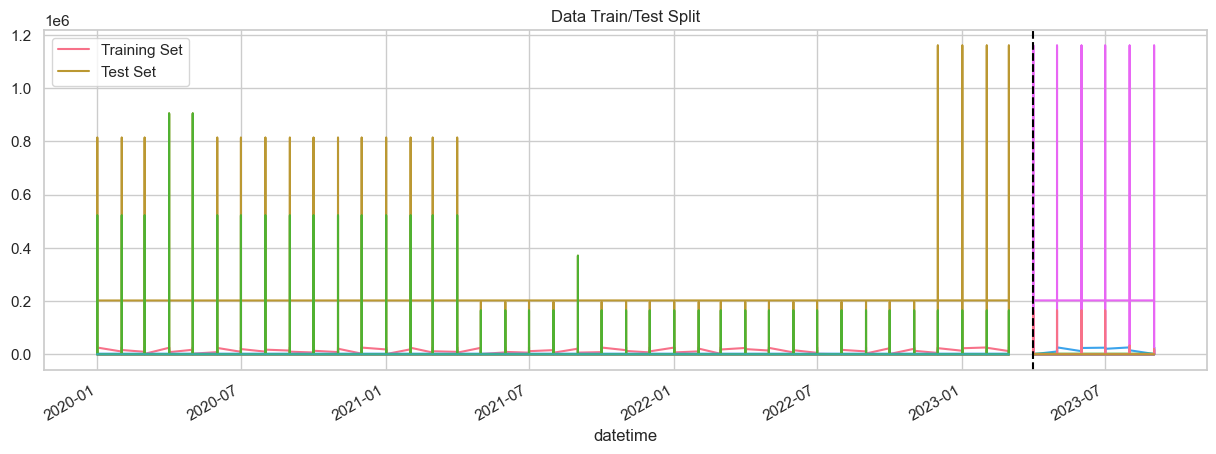

In [535]:
#df.set_index('datetime', inplace=True)
filtered_data.drop("mcc_id" , axis=1, inplace=True)
filtered_data.drop("working_type" , axis=1, inplace=True)

lbe = LabelEncoder()
filtered_data['merchant_id'] = lbe.fit_transform(filtered_data['merchant_id'])

filtered_data = pd.get_dummies(filtered_data, columns= ["merchant_segment", "merchant_source_name", "settlement_period"], drop_first=True)  # One-hot encode categorical variables if necessary

filtered_data = filtered_data.astype('int64')

train = filtered_data.loc[filtered_data.index < '2023-04-01']
test = filtered_data.loc[filtered_data.index >= '2023-04-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2023-04-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [536]:
filtered_data = filtered_data.astype('int64')

filtered_data

,merchant_id,month_id,net_payment_count,month,year,summer_solstice,black_friday,m,latest_non_zero_net_payment_count,merchant_segment_Segment - 2,merchant_segment_Segment - 3,merchant_segment_Segment - 4,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 2,settlement_period_Settlement Period - 3
datetime,,,,,,,,,,,,,,,,
2020-01-01,0,202001,0,1,2020,0,0,3,3,0,0,1,1,0,0,0
2020-02-01,0,202002,0,2,2020,0,0,3,3,0,0,1,1,0,0,0
2020-03-01,0,202003,0,3,2020,0,0,3,3,0,0,1,1,0,0,0
2020-04-01,0,202004,0,4,2020,0,0,3,3,0,0,1,1,0,0,0
2020-05-01,0,202005,0,5,2020,0,0,3,3,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,26052,202305,0,5,2023,0,0,8,4,0,0,1,1,0,0,0
2023-06-01,26052,202306,4,6,2023,1,0,8,4,0,0,1,1,0,0,0
2023-07-01,26052,202307,0,7,2023,0,0,8,4,0,0,1,1,0,0,0


In [537]:
train.shape, test.shape

((1015488, 16), (156176, 16))

In [538]:
X_train = train.drop(columns=['net_payment_count'])
y_train = train['net_payment_count']

X_test = test.drop(columns=['net_payment_count'])
y_test = test['net_payment_count']

In [539]:
import xgboost as xgb

def train_xgboost_model(X_train, y_train, X_test, y_test):
    # Define the XGBoost regressor
    model = xgb.XGBRegressor(
        objective='reg:absoluteerror',  # Use squared error as the objective function
        n_estimators=100,              # Number of boosting rounds
        max_depth=6,                   # Maximum tree depth
        learning_rate=0.1,             # Learning rate
        subsample=0.8,                 # Subsample ratio of the training instance
        colsample_bytree=0.8,          # Subsample ratio of columns when constructing each tree
        random_state=42                # Random seed for reproducibility
    )
    
    # Train the model
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],  # Use validation set for early stopping
        early_stopping_rounds=10,      # Stop if performance doesn't improve for 10 rounds
        verbose=10                    # Print progress every 10 rounds
    )
    
    return model

# Assuming you have features X_train, X_test, and target variables y_train, y_test
# Train the XGBoost model
xgb_model = train_xgboost_model(X_train, y_train, X_test, y_test)


[0]	validation_0-mae:26.02556
[10]	validation_0-mae:24.32829
[20]	validation_0-mae:23.15318
[30]	validation_0-mae:21.42632
[40]	validation_0-mae:20.22208
[50]	validation_0-mae:19.80235
[60]	validation_0-mae:19.16012
[70]	validation_0-mae:18.91616
[80]	validation_0-mae:18.86929
[90]	validation_0-mae:18.67781
[99]	validation_0-mae:18.56684


In [540]:
y_pred = xgb_model.predict(X_test)
mean_absolute_error(y_test, y_pred)

18.56557087788062

Text(0.5, 0, 'Değişken Önem Düzeyleri')

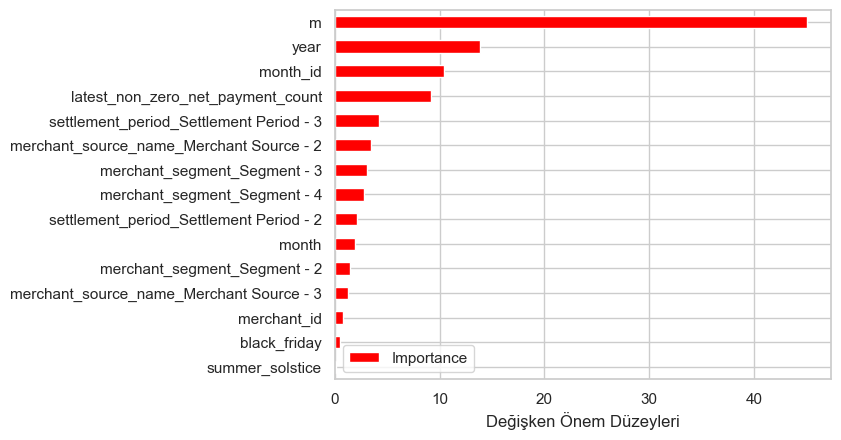

In [541]:
Importance = pd.DataFrame({"Importance": xgb_model.feature_importances_*100},
                         index = X_train.columns)
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")
plt.xlabel("Değişken Önem Düzeyleri")

In [542]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156176 entries, 2023-04-01 to 2023-09-01
Data columns (total 15 columns):
 #   Column                                    Non-Null Count   Dtype
---  ------                                    --------------   -----
 0   merchant_id                               156176 non-null  int64
 1   month_id                                  156176 non-null  int64
 2   month                                     156176 non-null  int64
 3   year                                      156176 non-null  int64
 4   summer_solstice                           156176 non-null  int64
 5   black_friday                              156176 non-null  int64
 6   m                                         156176 non-null  int64
 7   latest_non_zero_net_payment_count         156176 non-null  int64
 8   merchant_segment_Segment - 2              156176 non-null  int64
 9   merchant_segment_Segment - 3              156176 non-null  int64
 10  merchant_segment_Segment - 4

In [543]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1171664 entries, 2020-01-01 to 2023-09-01
Data columns (total 16 columns):
 #   Column                                    Non-Null Count    Dtype
---  ------                                    --------------    -----
 0   merchant_id                               1171664 non-null  int64
 1   month_id                                  1171664 non-null  int64
 2   net_payment_count                         1171664 non-null  int64
 3   month                                     1171664 non-null  int64
 4   year                                      1171664 non-null  int64
 5   summer_solstice                           1171664 non-null  int64
 6   black_friday                              1171664 non-null  int64
 7   m                                         1171664 non-null  int64
 8   latest_non_zero_net_payment_count         1171664 non-null  int64
 9   merchant_segment_Segment - 2              1171664 non-null  int64
 10  merchant_segmen

In [544]:
import re


# Load the sample_submission data
sample_submission_predicted = sample_submission.copy()



# Extract month_id and merchant_id from the 'id' column in sample_submission
sample_submission_predicted['month_id'] = sample_submission_predicted['id'].str[:6].astype(int)
sample_submission_predicted['merchant_id'] = sample_submission_predicted['id'].str[6:]

sample_submission_predicted['merchant_id'] = sample_submission_predicted['merchant_id'].apply(lambda x: re.search(r'_(\d+)$', x).group(1))


# Convert month_id column in filtered_data to int64 if it's not already
filtered_data['month_id'] = filtered_data['month_id'].astype(int)
filtered_data['merchant_id'] = filtered_data['merchant_id'].astype(int)
sample_submission_predicted['merchant_id'] = sample_submission_predicted['merchant_id'].astype(int)

filtered_data.reset_index(drop=True, inplace=True)
sample_submission_predicted.reset_index(drop=True, inplace=True)


# Merge the prediction data with the trained model data
merged_data = pd.concat([sample_submission_predicted, filtered_data], axis=1, join='inner')

df = merged_data.copy()
# Find duplicate column names
# Find duplicate column names
duplicate_columns = df.columns[df.columns.duplicated()].tolist()

# Drop subsequent occurrences of duplicate columns, keeping only the first occurrence
df = df.loc[:, ~df.columns.duplicated()]

# Extract features for prediction
X_predict = df[['merchant_id', 'month_id', 'month', 'year', 'summer_solstice', 'black_friday',
                     #    'avg_net_payment_count', 
                'm', 'latest_non_zero_net_payment_count',
                         'merchant_segment_Segment - 2', 'merchant_segment_Segment - 3', 'merchant_segment_Segment - 4',
                         'merchant_source_name_Merchant Source - 2', 'merchant_source_name_Merchant Source - 3',
                         'settlement_period_Settlement Period - 2', 'settlement_period_Settlement Period - 3']]



# Now you can make predictions using the trained model
# Assuming your trained model is stored in a variable called model
predictions = xgb_model.predict(X_predict)

# Update the prediction data DataFrame with the predicted net_payment_count
sample_submission_predicted['net_payment_count'] = predictions

# Display the predictions
print(sample_submission_predicted[['id', 'net_payment_count']])

                         id  net_payment_count
0      202311merchant_36004           0.000000
1      202312merchant_36004           0.000000
2      202310merchant_36004           0.000000
3      202311merchant_23099           0.000000
4      202312merchant_23099           0.000000
...                     ...                ...
78175  202312merchant_35969           0.221617
78176  202310merchant_35969           0.221617
78177   202311merchant_8429           0.385478
78178   202312merchant_8429           0.385478
78179   202310merchant_8429           0.697288

[78180 rows x 2 columns]


In [545]:
sample_submission_predicted

,id,net_payment_count,month_id,merchant_id
0,202311merchant_36004,0.000000,202311,36004
1,202312merchant_36004,0.000000,202312,36004
2,202310merchant_36004,0.000000,202310,36004
3,202311merchant_23099,0.000000,202311,23099
4,202312merchant_23099,0.000000,202312,23099
...,...,...,...,...
78175,202312merchant_35969,0.221617,202312,35969
78176,202310merchant_35969,0.221617,202310,35969
78177,202311merchant_8429,0.385478,202311,8429
78178,202312merchant_8429,0.385478,202312,8429


In [546]:
sample_submission_predicted

,id,net_payment_count,month_id,merchant_id
0,202311merchant_36004,0.000000,202311,36004
1,202312merchant_36004,0.000000,202312,36004
2,202310merchant_36004,0.000000,202310,36004
3,202311merchant_23099,0.000000,202311,23099
4,202312merchant_23099,0.000000,202312,23099
...,...,...,...,...
78175,202312merchant_35969,0.221617,202312,35969
78176,202310merchant_35969,0.221617,202310,35969
78177,202311merchant_8429,0.385478,202311,8429
78178,202312merchant_8429,0.385478,202312,8429


In [547]:
columns_to_keep = ['id', 'net_payment_count']
file = sample_submission_predicted[columns_to_keep]

# Save to CSV to submit
file.to_csv('submission_file_2.csv', index=False)